In [1]:
import os
import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fastmri
from fastmri.data import transforms as T
from fastmri.data.mri_data import fetch_dir
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule
from fastmri.pl_modules import UnetModule
import torch
import logging
from datetime import datetime
import torch.optim as optim
from torch.utils.data import DataLoader
import logging
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import h5py
from scipy.ndimage import rotate
from torch.utils.data import Dataset, DataLoader, DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp

### TESTING DISTRIBUTED PYTORCH

In [2]:
print(torch.distributed.is_available())

True


In [3]:
def setup(rank, world_size):
    dist.init_process_group(backend='nccl', init_method='tcp://127.0.0.1:29500', rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)

def cleanup():
    dist.destroy_process_group()

def test_distributed(rank, world_size):
    setup(rank, world_size)

    # Create a tensor with the value equal to the rank
    tensor = torch.tensor([rank], dtype=torch.float32).to(rank)

    print(f"\nBefore All-Reduce, Rank {rank}: {tensor}, device='cuda:{rank}'", flush = True)

    # Perform an All-Reduce operation (sum up all tensors across ranks)
    dist.all_reduce(tensor, op=dist.ReduceOp.SUM)

    print(f"\nAfter All-Reduce, Rank {rank}: {tensor}, device='cuda:{rank}'", flush = True)

    cleanup()

def run_distributed(world_size):
    processes = []
    for rank in range(world_size):
        p = mp.Process(target=test_distributed, args=(rank, world_size))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

In [4]:
# Define world size (number of GPUs)
world_size = torch.cuda.device_count()  # or set manually to 4 if you have 4 GPUs
print("Number of GPUs: ",world_size)

Number of GPUs:  3


In [5]:
# Run distributed process
run_distributed(world_size)


Before All-Reduce, Rank 0: tensor([0.], device='cuda:0'), device='cuda:0'

Before All-Reduce, Rank 1: tensor([1.], device='cuda:1'), device='cuda:1'

Before All-Reduce, Rank 2: tensor([2.], device='cuda:2'), device='cuda:2'

After All-Reduce, Rank 2: tensor([3.], device='cuda:2'), device='cuda:2'
After All-Reduce, Rank 1: tensor([3.], device='cuda:1'), device='cuda:1'


After All-Reduce, Rank 0: tensor([3.], device='cuda:0'), device='cuda:0'


### DATASET PREPROCESSING

In [3]:
# Load configuration from the YAML file
config_file = "/eng/home/koushani/Documents/MR_KReconstruction/root/config/config.yml"
with open(config_file, 'r') as file:
    config = yaml.safe_load(file)

In [4]:
# Device and model configuration
device = config['device']  # Use device specified in config
epochs = config['EPOCHS']# Use epochs from config
debug_input_size = config['debug_input_size']
debug = config['debug'] 
batch_size = config['batch_size']
num_workers = config['num_workers']
log_directory = config['log_directory']

In [5]:
def setup_logger(log_directory, resume=False): 
    """
    Set up a logger that writes logs to a .txt file in the logs directory.

    Args:
        log_directory (str): Directory where the checkpoint is saved.
        resume (bool): Whether training is resuming from an existing checkpoint.

    Returns:
        logger (logging.Logger): Configured logger instance.
    """
    # Ensure logs directory exists
    logs_dir = os.path.join(os.path.dirname(log_directory), 'logs/UNet')
    os.makedirs(logs_dir, exist_ok=True)

    # Determine log file name based on whether we are resuming training or not
    if resume:
        # Resume from the same log file if resuming from a checkpoint
        log_file_name = os.path.basename(log_directory).split('.')[0] + '.txt'
    else:
        # Create a new log file with timestamp if starting a new checkpoint
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        log_file_name = f'log_MR_Reconstruction_UNet_{timestamp}.txt'
    
    log_file_path = os.path.join(logs_dir, log_file_name)

    # Create the logger name with timestamp
    logger_name = f'{datetime.now().strftime("%Y%m%d_%H%M%S")}'
    
    # Configure the logger
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    
    # File handler to write logs to the file
    fh = logging.FileHandler(log_file_path)
    fh.setLevel(logging.INFO)
    
    # Console handler to output logs to the console
    ch = logging.StreamHandler()
    ch.setLevel(logging.INFO)
    
    # Formatter for both handlers
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    fh.setFormatter(formatter)
    ch.setFormatter(formatter)
    
    # Add handlers to the logger
    if not logger.hasHandlers():  # To prevent adding handlers multiple times
        logger.addHandler(fh)
        logger.addHandler(ch)
    
    return logger

In [6]:
# Function to analyze files in a directory
def analyze_directory(directory_path):
    file_count = 0
    total_size = 0
    file_types = {}
    
    for root, _, files in os.walk(directory_path):
        for file in files:
            file_count += 1
            file_path = os.path.join(root, file)
            file_size = os.path.getsize(file_path)
            total_size += file_size
            
            file_extension = os.path.splitext(file)[1]
            if file_extension in file_types:
                file_types[file_extension] += 1
            else:
                file_types[file_extension] = 1
    
    return file_count, total_size, file_types

In [7]:
# Expand variables manually
root_dir = config['root_dir']
train_dir = config['singlecoil_knee_train'].replace('${root_dir}', root_dir)
val_dir = config['singlecoil_knee_val'].replace('${root_dir}', root_dir)
test_dir = config['singlecoil_knee_test'].replace('${root_dir}', root_dir)
MAX_HEIGHT = config['MAX_HEIGHT']
MAX_WIDTH = config['MAX_WIDTH']

In [8]:
# Debug print to check paths
print(f"Root directory: {root_dir}")
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

Root directory: /data2/users/koushani/FAST_MRI_data
Training directory: /data2/users/koushani/FAST_MRI_data/singlecoil_train/
Validation directory: /data2/users/koushani/FAST_MRI_data/singlecoil_val/
Test directory: /data2/users/koushani/FAST_MRI_data/singlecoil_test/


In [9]:
# Check if directories exist
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        print(f"Directory does not exist: {dir_path}")

In [10]:
# Analyze each directory
train_files, train_size, train_types = analyze_directory(train_dir)
val_files, val_size, val_types = analyze_directory(val_dir)
test_files, test_size, test_types = analyze_directory(test_dir)

# Convert sizes to MB
train_size_mb = train_size / (1024 * 1024)
val_size_mb = val_size / (1024 * 1024)
test_size_mb = test_size / (1024 * 1024)

In [11]:
# Print summary
print(f"Training Data: {train_files} files, {train_size_mb:.2f} MB, File types: {train_types}")
print(f"Validation Data: {val_files} files, {val_size_mb:.2f} MB, File types: {val_types}")
print(f"Test Data: {test_files} files, {test_size_mb:.2f} MB, File types: {test_types}")

Training Data: 973 files, 89772.75 MB, File types: {'.h5': 973}
Validation Data: 199 files, 18477.81 MB, File types: {'.h5': 199}
Test Data: 108 files, 7053.53 MB, File types: {'.h5': 108}


In [12]:
# Function to extract central slices from the second dimension (width 640)
def extract_central_slices(kspace_data, num_central_slices):
    """
    Extract central 'n' slices along the width dimension (640).
    :param kspace_data: The k-space data with shape (num_slices, height, width).
    :param num_central_slices_width: The number of central width slices to extract (300 in this case).
    :return: The k-space data with central width slices extracted.
    """
    # Extract width (640 dimension)
    num_width = kspace_data.shape[0]  # 640
    center_width = num_width // 2  # Center of 640

    # Start and end indices for central width slices
    start_idx = center_width - (num_central_slices // 2)
    end_idx = start_idx + num_central_slices

    # Extract the central width slices
    return kspace_data[start_idx:end_idx,:,: ]  # Apply along the first dimension


In [13]:
def filter_valid_files(root_dir, max_height=368, CFG=None):
    """
    Preprocess and filter valid files based on the height' dimension, with an optional debug flag.
    :param root_dir: Path to the directory containing .h5 files.
    :param max_height: Maximum allowable height' (default is 368).
    :param CFG: Configuration dictionary. Expects 'debug' and 'debug_input_size' keys if debugging is enabled.
    :return: List of valid file paths where height' <= max_height.
    """
    valid_files = []
    for file_name in os.listdir(root_dir):
        if file_name.endswith('.h5'):
            file_path = os.path.join(root_dir, file_name)
            with h5py.File(file_path, 'r') as f:
                kspace_data = f['kspace'][:]
                # Transpose to axial orientation and check height'
                axial_slices = np.transpose(kspace_data, (1, 2, 0))
                height_prime = axial_slices.shape[1]  # height' is in the second dimension
                if height_prime <= max_height:
                    valid_files.append(file_name)
    
    # If debug mode is enabled, sample from the valid files
    if debug:
        valid_files_df = pd.DataFrame(valid_files, columns=['file_name'])  # Convert list to DataFrame for sampling
        
        if 0 < debug_input_size <= 1:  # If debug_input_size is a percentage
            sample_size = int(debug_input_size * len(valid_files_df))  # Calculate the number of files to sample
        else:
            sample_size = debug_input_size  # If it's a fixed number
        
        # Ensure the sample size does not exceed the available files
        sample_size = min(sample_size, len(valid_files_df))
        
        valid_files_sampled = valid_files_df.sample(sample_size)
        valid_files = valid_files_sampled['file_name'].tolist()  # Convert back to a list
    return valid_files

In [14]:
filtered_train_files = filter_valid_files(train_dir)
filtered_valid_files = filter_valid_files(val_dir)

In [18]:
print(len(filtered_train_files))
print(len(filtered_valid_files))

114
21


In [15]:
# Correcting the file path if needed
file_path = os.path.join(train_dir, 'file1001206.h5')
print(f"Corrected file path: {file_path}") # Replace with the actual file path

# Open the HDF5 file
with h5py.File(file_path, 'r') as hf:
    # List all groups
    print("Keys in the file:", list(hf.keys()))

Corrected file path: /data2/users/koushani/FAST_MRI_data/singlecoil_train/file1001206.h5
Keys in the file: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']


In [16]:
hf = h5py.File(file_path)
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_esc', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPD_FBK', 'max': 0.0009848569827773906, 'norm': 0.2780016598027961, 'patient_id': '58f27fcbe2c48252729051b913b33ddbccea387111af3ef5dfe6b3d36ac7416c'}


In [17]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(33, 640, 368)


In [18]:
# Check the shape of the extracted slices
print(f"Shape of data: {volume_kspace.shape}")

Shape of data: (33, 640, 368)


In [20]:
kspace2 = T.to_tensor(volume_kspace)
image = fastmri.ifft2c(kspace2)
image_abs = fastmri.complex_abs(image)
# Convert image to numpy array for visualization
image_np = image_abs.numpy()
# Permute dimensions (equivalent of permute in MATLAB)
# axial_image = np.transpose(image_np, (1, 2, 0))  # Switch axes 1 and 2
print(f"Shape of data: {image_np.shape}")

Shape of data: (33, 640, 368)


In [22]:
trimmed_axial_image = extract_central_slices(image_np,15)
trimmed_axial_image.shape

(15, 640, 368)

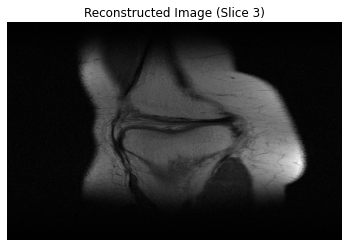

In [23]:
# Plot the image (slice at index 300)
plt.figure()
plt.imshow((trimmed_axial_image[3, :, :]), cmap='gray', aspect='auto')  # Using index 299 for the 300th slice
plt.title('Reconstructed Image (Slice 3)')
plt.axis('off')
plt.show()

In [24]:
class AxialMRIDataset(Dataset):
    def __init__(self, valid_files, root_dir, num_central_slices=300, max_height=368, max_width=50):
        """
        Initialize the dataset by loading the list of valid .h5 files and setting parameters.
        :param valid_files: List of valid .h5 files.
        :param num_central_slices: Number of central axial slices to extract (default is 300).
        :param max_height: Maximum height to filter slices (default is 368).
        :param max_width: Maximum width for padding/truncating (default is 50).
        """
        
        self.valid_files = valid_files
        self.root_dir =  root_dir
        self.num_central_slices = num_central_slices
        self.max_height = max_height  # We will filter based on this height
        self.max_width = max_width

    def extract_central_slices(self, axial_slices):
        """
        Extract the central 'n' slices along the axial direction.
        :param axial_slices: Tensor of axial slices (shape: slice', height', width').
        """
        num_slices = axial_slices.shape[0]  # This is the slice' dimension (axial slices)
        center_slice = num_slices // 2
        start_idx = center_slice - (self.num_central_slices // 2)
        end_idx = start_idx + self.num_central_slices
        return axial_slices[start_idx:end_idx, :, :]

    def visualize_axial_image(self, image):
        """
        Visualize the axial image sample.
        :param image: The image data tensor with shape (1, 368, 50).
        """

        # Convert to numpy for visualization
        axial_image = image.numpy()
        print(axial_image.shape)

        # Plot the axial image
        plt.figure(figsize=(8, 8))
        plt.imshow(axial_image[0], cmap='gray')
        plt.title('Axial Image')
        plt.axis('off')
        plt.show()

    def pad_to_final_shape(self, data, target_shape):
        """
        Pad/truncate the input data (image or k-space) to the desired shape.
        :param data: Input tensor of shape (channels, height, width).
        :param target_shape: The desired shape, e.g., (channels, 368, 50).
        """
        current_shape = data.shape
        pad_height = max(0, target_shape[1] - current_shape[1])  # Difference in height
        pad_width = max(0, target_shape[2] - current_shape[2])    # Difference in width

        # Apply symmetric padding
        padding = (pad_width // 2, pad_width - (pad_width // 2),  # Left-Right padding
                   pad_height // 2, pad_height - (pad_height // 2))  # Top-Bottom padding

        # Apply padding or trimming
        padded_data = F.pad(data, padding, mode='constant', value=0)

        return padded_data

    def __len__(self):
        return len(self.valid_files) * self.num_central_slices

    def __getitem__(self, idx):
        # Find which file this index corresponds to
        file_idx = idx // self.num_central_slices
        slice_idx = idx % self.num_central_slices
        
        file_name = self.valid_files[file_idx]
        file_path = os.path.join(self.root_dir, file_name)

        # Load the k-space data from the H5 file
        with h5py.File(file_path, 'r') as f:
            kspace_data = f['kspace'][:]  # Shape: (slice, height, width)
        
        kspace2 = T.to_tensor(kspace_data)
        image = fastmri.ifft2c(kspace2)
        image_abs = fastmri.complex_abs(image)
        
        # Transpose the k-space data to get axial slices: new shape (height', width', slice')
        axial_slices = np.transpose(image_abs, (1, 2, 0))
        
        # Extract central 'n' axial slices (along height dimension, now treated as slice')
        central_axial_slices = self.extract_central_slices(axial_slices)
        
        # Get the specific axial slice for this sample
        axial_sample = central_axial_slices[slice_idx]
        
        # Step 2: Normalize the image
        image_mean = axial_sample.mean()
        image_std = axial_sample.std()
        image_normalized = (axial_sample - image_mean) / image_std
        
        # Pad or truncate the normalized image to (368, 50)
        input_image = self.pad_to_final_shape(image_normalized.unsqueeze(0), (1, self.max_height, self.max_width))
        
        # Step 3: Convert the normalized image back to k-space
        image_complex = torch.stack([image_normalized, torch.zeros_like(image_normalized)], dim=-1)
        target_kspace = fastmri.fft2c(image_complex)  # Forward Fourier transform back to k-space

        # **Pad or truncate k-space**
        target_kspace_padded = self.pad_to_final_shape(target_kspace.permute(2, 0, 1), (2, self.max_height, self.max_width))

        # Return final sample: target (normalized and padded k-space) and input (padded image)
        return input_image, target_kspace_padded

In [93]:
class SagittalMRIDataset(Dataset):
    def __init__(self, valid_files, root_dir, num_slices=30, max_height=450, max_width=500):
        """
        Initialize the dataset by loading the list of valid .h5 files and setting parameters.
        :param valid_files: List of valid .h5 files.
        :param num_slices: Number of sagittal slices to extract (default is 37).
        :param max_height: Maximum height for padding/truncating (default is 450).
        :param max_width: Maximum width for padding/truncating (default is 500).
        """
        
        self.valid_files = valid_files
        self.root_dir = root_dir
        self.num_slices = num_slices
        self.max_height = max_height
        self.max_width = max_width
        
        
        
        

    def extract_central_slices(self, volume):
        """
        Extract the central 'n' sagittal slices along the first dimension.
        :param volume: Tensor of k-space data with shape (depth, height, width).
        """
        num_slices = volume.shape[0]
        center_slice = num_slices // 2
        start_idx = center_slice - (self.num_slices // 2)
        end_idx = start_idx + self.num_slices
        return volume[start_idx:end_idx, :, :]
    
    
    
    

    def pad_to_final_shape(self, data, target_shape):
        """
        Pad or truncate the input data (image or k-space) to the desired shape.
        :param data: Input tensor of shape (channels, height, width).
        :param target_shape: The desired shape, e.g., (channels, 450, 500).
        """
        current_shape = data.shape
        pad_height = max(0, target_shape[1] - current_shape[1])
        pad_width = max(0, target_shape[2] - current_shape[2])

        # Apply symmetric padding
        padding = (pad_width // 2, pad_width - (pad_width // 2),  # Left-Right padding
                pad_height // 2, pad_height - (pad_height // 2))  # Top-Bottom padding

        # Apply padding or trimming as needed
        padded_data = F.pad(data, padding, mode='constant', value=0)
        
        # If the height or width of `padded_data` exceeds the target, truncate it.
        if padded_data.size(1) > target_shape[1]:  # Truncate height if needed
            start_idx = (padded_data.size(1) - target_shape[1]) // 2
            padded_data = padded_data[:, start_idx:start_idx + target_shape[1], :]
            
        if padded_data.size(2) > target_shape[2]:  # Truncate width if needed
            start_idx = (padded_data.size(2) - target_shape[2]) // 2
            padded_data = padded_data[:, :, start_idx:start_idx + target_shape[2]]

        return padded_data
    
    
    
    def __len__(self):
        return len(self.valid_files) * self.num_slices
    
    
    

    def __getitem__(self, idx):
        # Find which file and slice this index corresponds to
        file_idx = idx // self.num_slices
        slice_idx = idx % self.num_slices
        
        file_name = self.valid_files[file_idx]
        file_path = os.path.join(self.root_dir, file_name)

        # Load the k-space data from the H5 file
        with h5py.File(file_path, 'r') as f:
            kspace_data = f['kspace'][:]  # Shape: (depth, height, width)

        # Check that the volume has enough slices for the intended number of sagittal slices
        if kspace_data.shape[0] < self.num_slices:
            raise ValueError(f"File {file_name} does not contain enough slices. Found {kspace_data.shape[0]}, expected at least {self.num_slices}.")

        kspace_tensor = T.to_tensor(kspace_data)  # Convert to torch tensor
        sagittal_slices = self.extract_central_slices(kspace_tensor)  # Extract central slices

        # Ensure slice_idx is within bounds after extracting central slices
        if slice_idx >= sagittal_slices.shape[0]:
            raise IndexError(f"slice_idx {slice_idx} is out of bounds for sagittal_slices with shape {sagittal_slices.shape}")

        # Get the specific sagittal slice for this sample
        sagittal_sample = sagittal_slices[slice_idx]  # Shape should be (height, width)
        
        # Step 1: Normalize the image
        image_abs = fastmri.complex_abs(sagittal_sample)  # Get the magnitude for image data
        image_mean = image_abs.mean()
        image_std = image_abs.std()
        image_normalized = (image_abs - image_mean) / image_std

        # Pad or truncate the normalized image to (450, 500)
        input_image = self.pad_to_final_shape(image_normalized.unsqueeze(0), (1, self.max_height, self.max_width))
        
        # Step 2: Convert the normalized image back to k-space with separate real and imaginary channels
        image_complex = torch.stack([image_normalized, torch.zeros_like(image_normalized)], dim=-1)
        target_kspace = fastmri.fft2c(image_complex.unsqueeze(0))  # Forward Fourier transform to k-space
        
        # Pad/truncate k-space to the target shape (2, 450, 500)
        target_kspace_padded = self.pad_to_final_shape(target_kspace.squeeze(0).permute(2, 0, 1), (2, self.max_height, self.max_width))

        # Return final sample: input image and target k-space with desired shapes
        return input_image, target_kspace_padded

In [94]:
# Pass the valid files to the dataset
mri_train_dataset = SagittalMRIDataset(valid_files=filtered_train_files, root_dir = train_dir)
mri_valid_dataset = SagittalMRIDataset(valid_files=filtered_valid_files, root_dir = val_dir)

In [95]:
print(f"Total axial samples generated (training): {len(mri_train_dataset)}")
print(f"Total axial samples generated (validation): {len(mri_valid_dataset)}")


Total axial samples generated (training): 5130
Total axial samples generated (validation): 930


In [97]:
input_image, target_kspace = mri_train_dataset[500]
input_image_valid, target_kspace_valid = mri_valid_dataset[500]
print("training input image shape: ", input_image.shape)
print("training target k-space shape: ", target_kspace.shape)
print("validation input image shape: ", input_image_valid.shape)
print("validation target k-space shape: ", target_kspace_valid.shape)

training input image shape:  torch.Size([1, 450, 500])
training target k-space shape:  torch.Size([2, 450, 500])
validation input image shape:  torch.Size([1, 450, 500])
validation target k-space shape:  torch.Size([2, 450, 500])


In [98]:
# Define the DataLoader
train_dataloader = DataLoader(mri_train_dataset, batch_size=batch_size, num_workers = num_workers, shuffle=True)
validation_dataloader = DataLoader(mri_valid_dataset, batch_size=batch_size, num_workers = num_workers, shuffle=True)
#test_dataloader = DataLoader(mri_test_dataset, batch_size=batch_size, num_workers = num_workers, shuffle=True)

# Set the number of batches to observe
n = 1  # You can change this to any value you want

# Iterate through the DataLoader and print batch shapes for n batches
for batch_idx, (kspace_batch, image_batch) in enumerate(train_dataloader):
    print(f"Training Batch {batch_idx + 1}:")
    print(f"  K-space batch shape: {kspace_batch.shape}")
    print(f"  Image batch shape: {image_batch.shape}")
    
    if batch_idx + 1 == n:  # Stop after n batches
        break
    
    
    
# Iterate through the DataLoader and print batch shapes for n batches
for batch_idx, (kspace_batch, image_batch) in enumerate(validation_dataloader):
    print(f"Validation Batch {batch_idx + 1}:")
    print(f"  K-space batch shape: {kspace_batch.shape}")
    print(f"  Image batch shape: {image_batch.shape}")
    
    if batch_idx + 1 == n:  # Stop after n batches
        break
    
# # Iterate through the DataLoader and print batch shapes for n batches
# for batch_idx, (kspace_batch, image_batch) in enumerate(test_dataloader):
#     print(f"Testing Batch {batch_idx + 1}:")
#     print(f"  K-space batch shape: {kspace_batch.shape}")
#     print(f"  Image batch shape: {image_batch.shape}")
    
#     if batch_idx + 1 == n:  # Stop after n batches
#         break

Training Batch 1:
  K-space batch shape: torch.Size([256, 1, 450, 500])
  Image batch shape: torch.Size([256, 2, 450, 500])
Validation Batch 1:
  K-space batch shape: torch.Size([256, 1, 450, 500])
  Image batch shape: torch.Size([256, 2, 450, 500])


### MODEL BUILDING AND TRAINING

In [31]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

def crop_tensor(input_tensor, target_tensor):
    """
    Crops the input_tensor to match the size of the target_tensor.
    Both tensors are assumed to have shape (batch_size, channels, height, width).
    """
    _, _, target_h, target_w = target_tensor.shape
    _, _, input_h, input_w = input_tensor.shape

    # Calculate cropping for height and width
    crop_h = (input_h - target_h) // 2
    crop_w = (input_w - target_w) // 2

    # Adjust the height if the dimensions do not match
    if input_h > target_h:
        input_tensor = input_tensor[:, :, crop_h:crop_h + target_h, :]
    elif input_h < target_h:
        # Pad the tensor if it's smaller
        padding_h = (target_h - input_h) // 2
        input_tensor = F.pad(input_tensor, (0, 0, padding_h, target_h - input_h - padding_h), mode='constant', value=0)

    # Adjust the width if the dimensions do not match
    if input_w > target_w:
        input_tensor = input_tensor[:, :, :, crop_w:crop_w + target_w]
    elif input_w < target_w:
        # Pad the tensor if it's smaller
        padding_w = (target_w - input_w) // 2
        input_tensor = F.pad(input_tensor, (padding_w, target_w - input_w - padding_w, 0, 0), mode='constant', value=0)

    return input_tensor

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Contracting path (Encoder)
        self.dconv_down1 = double_conv(1, 64)   # Input: 1 channel (grayscale)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        # Expansive path (Decoder)
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        # Final 1x1 convolution to output 2 channels (real + imaginary)
        self.conv_last = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        # Encoder (downsampling)
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        # Decoder (upsampling)
        x = self.upsample(x)
        #print(f"Upsampled x shape: {x.shape}, conv3 shape: {conv3.shape}")  # Debugging
        x = crop_tensor(x, conv3)  # Crop to match conv3
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        #print(f"Upsampled x shape: {x.shape}, conv2 shape: {conv2.shape}")  # Debugging
        x = crop_tensor(x, conv2)  # Crop to match conv2
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        #print(f"Upsampled x shape: {x.shape}, conv1 shape: {conv1.shape}")  # Debugging
        x = crop_tensor(x, conv1)  # Crop to match conv1
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        # Output 2 channels (real + imaginary)
        out = self.conv_last(x)

        return out

In [32]:
# Create an instance of the UNet model
model = UNet()  # For k-space output with 2 channels (real and imaginary)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

print(model)

UNet(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kerne

In [33]:
# Define the NMSE function
def nmse(predicted, target):
    mse = torch.mean((predicted - target) ** 2)
    norm_factor = torch.mean(target ** 2)
    nmse_value = mse / norm_factor
    return nmse_value.item()

In [34]:
# Setup for Distributed Training
def setup_training(rank, world_size):
    dist.init_process_group(backend='nccl', init_method='tcp://127.0.0.1:29500', rank=rank, world_size=world_size)
    torch.cuda.set_device(rank)
    
def cleanup_training():
    dist.destroy_process_group()

In [35]:
# Load checkpoint function
def load_checkpoint(checkpoint_dir, checkpoint_filename, model, optimizer, new_checkpoint=False):
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    
    if not new_checkpoint and os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint '{checkpoint_path}'")
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda', torch.cuda.current_device()))
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch']
        train_losses = checkpoint['train_losses']
        valid_losses = checkpoint['valid_losses']
        train_accuracies = checkpoint['train_accuracies']
        valid_accuracies = checkpoint['valid_accuracies']
        print(f"Loaded checkpoint from epoch {start_epoch}")
    else:
        if new_checkpoint:
            print(f"Creating a new checkpoint at '{checkpoint_path}'")
        else:
            print(f"No checkpoint found at '{checkpoint_path}', starting fresh.")
        start_epoch = 0
        train_losses = []
        valid_losses = []
        train_accuracies = []
        valid_accuracies = []

    return start_epoch, train_losses, valid_losses, train_accuracies, valid_accuracies

In [36]:
# Save checkpoint function
def save_checkpoint(state, checkpoint_dir, checkpoint_filename):
    checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
    torch.save(state, checkpoint_path)
    print(f"Checkpoint saved at '{checkpoint_path}'")

In [37]:
# Define the training loop with logging and NMSE accuracy for Distributed Data Parallel with checkpointing
def train_model(rank, world_size, model, train_dataset, valid_dataset, epochs=10, lr=1e-4, device='cuda', log_directory="log_dir", resume=False, checkpoint_dir="checkpoints", checkpoint_filename="model_checkpoint.pth", new_checkpoint=False):
    # Setup Distributed Training
    setup(rank, world_size)

    # Send model to the appropriate device and wrap with DistributedDataParallel
    model = model.to(rank)
    model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Load checkpoint if available
    start_epoch, train_losses, valid_losses, train_accuracies, valid_accuracies = load_checkpoint(
        checkpoint_dir, checkpoint_filename, model, optimizer, new_checkpoint=new_checkpoint)

    # Use DistributedSampler to ensure each process gets a subset of the data
    train_sampler = DistributedSampler(train_dataset, num_replicas=world_size, rank=rank)
    valid_sampler = DistributedSampler(valid_dataset, num_replicas=world_size, rank=rank)

    # Create data loaders with the distributed sampler
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=32, sampler=valid_sampler)

    # Set up the logger (log only on the main process, i.e., rank 0)
    if rank == 0:
        logger = setup_logger(log_directory, resume)
        logger.info("Starting Training")

    # Track losses and accuracies
    for epoch in range(start_epoch, epochs):
        model.train()
        running_train_loss = 0.0
        running_train_nmse = 0.0
        
        train_sampler.set_epoch(epoch)  # Shuffle data differently each epoch
        for i, (image_batch, kspace_batch) in enumerate(train_loader):
            kspace_batch = kspace_batch.to(rank)
            image_batch = image_batch.to(rank)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass: Get the reconstructed image from UNet model
            outputs = model(image_batch)
            
            # Compute the loss
            loss = criterion(outputs, kspace_batch)
            
            # Backward pass: Compute gradients
            loss.backward()
            
            # Update model parameters
            optimizer.step()
            
            # Accumulate loss
            running_train_loss += loss.item()
            
            # Compute NMSE
            batch_nmse = nmse(outputs, kspace_batch)
            running_train_nmse += batch_nmse
            
            if rank == 0 and (i + 1) % 100 == 0:
                logger.info(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], "
                            f"Training Loss: {loss.item():.4f}, NMSE: {batch_nmse:.4f}")
        
        # Validation phase
        model.eval()
        running_valid_loss = 0.0
        running_valid_nmse = 0.0
        with torch.no_grad():
            for image_batch, kspace_batch in valid_loader:
                kspace_batch = kspace_batch.to(rank)
                image_batch = image_batch.to(rank)

                # Forward pass
                outputs = model(image_batch)

                # Compute validation loss
                loss = criterion(outputs, kspace_batch)
                running_valid_loss += loss.item()

                # Compute NMSE
                batch_nmse = nmse(outputs, kspace_batch)
                running_valid_nmse += batch_nmse

        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_nmse = running_train_nmse / len(train_loader)
        avg_valid_loss = running_valid_loss / len(valid_loader)
        avg_valid_nmse = running_valid_nmse / len(valid_loader)

      # Log the results for all ranks
        avg_train_loss = running_train_loss / len(train_loader)
        avg_train_nmse = running_train_nmse / len(train_loader)
        avg_valid_loss = running_valid_loss / len(valid_loader)
        avg_valid_nmse = running_valid_nmse / len(valid_loader)

        # Log for each rank
        logger.info(f"Rank [{rank}] - Epoch [{epoch+1}/{epochs}] completed. "
                    f"Avg Train Loss: {avg_train_loss:.4f}, Train NMSE: {avg_train_nmse:.4f}, "
                    f"Avg Valid Loss: {avg_valid_loss:.4f}, Valid NMSE: {avg_valid_nmse:.4f}")

        # Save checkpoint
        state = {
            'epoch': epoch + 1,  # Save the next epoch number
            'state_dict': model.module.state_dict(),
            'optimizer': optimizer.state_dict(),
            'train_losses': train_losses,
            'valid_losses': valid_losses,
            'train_accuracies': train_accuracies,
            'valid_accuracies': valid_accuracies
        }
        save_checkpoint(state, checkpoint_dir, checkpoint_filename)

    cleanup()

In [38]:
def run_distributed_training(model, train_dataset, valid_dataset, world_size, epochs=10, lr=1e-4, device='cuda', log_directory="log_dir", resume=False, checkpoint_dir="checkpoints", checkpoint_filename="model_checkpoint.pth", new_checkpoint=False):
    mp.spawn(train_model,
             args=(world_size, model, train_dataset, valid_dataset, epochs, lr, device, log_directory, resume, checkpoint_dir, checkpoint_filename, new_checkpoint),
             nprocs=world_size,
             join=True)

In [40]:
run_distributed_training(model, train_dataloader, validation_dataloader, world_size, epochs=epochs, lr=1e-4)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'train_model' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/usr/lib/python3.10/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'train_model' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File 

ProcessExitedException: process 2 terminated with exit code 1